In [1]:
#combine files 
import glob 
import os
#clean 
import string
import pandas as pd
import numpy as np
import emoji
import nltk
import re 
from cleantext import clean
#sleep timer 
import time 
import logging
import threading
#show most common words
from collections import Counter
#word cloud 
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('J&TExpressJakarta .csv')
column_titles = ['rating','caption']
df1 = df.reindex(columns=column_titles)
df1 = df1.dropna()

In [3]:
df1['middle'] = df1['caption'].str.split(")").str[1] 
df1['reviews'] = df1['middle'].str.split("(").str[0]

df1 = df1.reset_index()

In [4]:
df1['reviews'].fillna('0', inplace = True)
for i, row in df1.iterrows(): 
    review = row['reviews']
    if review == '0':
        df1['reviews'][i] = review.replace('0', row['caption'])

/var/folders/5w/0kxl7gbj5vqb93sccvkxwrzc0000gn/T/ipykernel_53874/1854476216.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['reviews'][i] = review.replace('0', row['caption'])


### Clean the data

In [5]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

def clean_text_round1(text):
    '''Make text lowercase, remove punctuation, remove words containing numbers and lemmatize/stem.'''
    text = str(text).lower()
    text = re.sub('#\w*', '', text)
    text = re.sub('@\w*', '', text)    
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = clean(text, no_emoji=True)
    text = emoji.demojize(text, delimiters=("", "")) #change emoji into text 
    text = ' '.join([word for word in text.split() if word not in (stop)])
    return text

# Let's take a look at the updated text
df1['reviews'] = pd.DataFrame(df1['reviews'].apply(clean_text_round1))
df1

,index,rating,caption,middle,reviews
0,1,1.0,"Pengiriman jauh melebihi batas waktu, manajeme...",NaN,pengiriman jauh melebihi batas waktu manajemen...
1,2,1.0,worst of the worst! DO NOT USE them as your co...,NaN,worst worst use courier youll regret later unp...
2,6,5.0,(Translated by Google) Good (Original) Baik,Good (Original,good
3,7,1.0,(Translated by Google) the call center on what...,the call center on whatsapp was answered by B...,call center whatsapp answered bot email custom...
4,8,1.0,(Translated by Google) Why was my J&T notified...,Why was my J&T notified that my package had a...,jt notified package arrived wasnt place explai...
...,...,...,...,...,...
777,1009,5.0,(Translated by Google) Because j & t express i...,Because j & t express is delivering goods rig...,j express delivering goods right fast safe god...
778,1011,1.0,(Translated by Google) My niece's package hasn...,"My niece's package hasn't arrived until now, ...",nieces package hasnt arrived even though sent ...
779,1015,5.0,(Translated by Google) The location is easy to...,The location is easy to find ' (Original,location easy find
780,1016,5.0,"(Translated by Google) Great service, bro ... ...","Great service, bro ... (Original",great service bro


### Sentiment analysis 


In [6]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
def clean_text_round2(text):
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

df1['reviews'] = pd.DataFrame(df1['reviews'].apply(clean_text_round2))

In [7]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def sentiment_scores(sentence):
    sid_obj = SentimentIntensityAnalyzer() 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    if sentiment_dict['compound'] >= 0.05 : 
       return "Positive"
    elif sentiment_dict['compound'] <= - 0.05 : 
        return "Negative"
    else : 
       return "Neutral"
        
df1['sentiment'] = pd.DataFrame(df1['reviews'].apply(sentiment_scores))

In [8]:
column_titles = ['rating','reviews','sentiment']
df1 = df1.reindex(columns=column_titles)
df1.to_csv('jnt_Greviews.csv')

In [11]:
df_neg = df1.drop(df1[df1['sentiment'] != 'Negative'].index)
df_neg

,rating,reviews,sentiment
1,1.0,worst worst use courier youll regret later unp...,Negative
5,1.0,slow work item ordered still even delivery att...,Negative
11,1.0,dont want close company forever burden world n...,Negative
12,1.0,service bad short distance delivery take day ...,Negative
16,1.0,badly broken,Negative
...,...,...,...
759,1.0,shouldnt need give star long delivery time arr...,Negative
760,1.0,j possible dont give star half star complain r...,Negative
767,1.0,worst shipping expectoration item hasnt said a...,Negative
768,1.0,possible wont even give star package batam ban...,Negative


In [12]:
#combining the text into one long string for word cloud 
cloud_string = df_neg['reviews'].str.cat(sep=' ')

In [13]:
# Let's first pull out the top 30 words for each category
words = []
for word in cloud_string.split():
        words.append(word)
Counter(words).most_common()

[('...', 236),
 ('package', 125),
 ('service', 98),
 ('bad', 87),
 ('day', 85),
 ('delivery', 59),
 ('arrived', 59),
 ('even', 52),
 ('jakarta', 51),
 ('sent', 46),
 ('really', 45),
 ('time', 44),
 ('use', 42),
 ('courier', 42),
 ('good', 39),
 ('though', 36),
 ('expedition', 35),
 ('jt', 34),
 ('arrive', 33),
 ('disappointed', 33),
 ('still', 32),
 ('item', 32),
 ('long', 32),
 ('j', 31),
 ('worst', 28),
 ('shipping', 28),
 ('hasnt', 27),
 ('jnt', 27),
 ('didnt', 25),
 ('address', 24),
 ('warehouse', 23),
 ('c', 22),
 ('week', 21),
 ('dont', 20),
 ('call', 20),
 ('using', 19),
 ('already', 19),
 ('send', 19),
 ('received', 18),
 ('phone', 18),
 ('express', 17),
 ('want', 16),
 ('doesnt', 16),
 ('customer', 15),
 ('slow', 15),
 ('worse', 15),
 ('severe', 15),
 ('center', 15),
 ('give', 15),
 ('take', 14),
 ('stuck', 14),
 ('star', 14),
 ('lost', 13),
 ('many', 13),
 ('disappointing', 13),
 ('instead', 13),
 ('delivered', 12),
 ('wrong', 12),
 ('said', 12),
 ('company', 11),
 ('know', 1

In [14]:
#add meaningless words to stopwords
add_stop_words = ['...' , 'call', 'dont', 'cant']
stop_words = add_stop_words + stop 

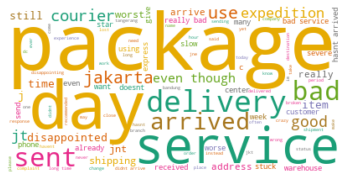

In [15]:
#wordcloud for top 100 words 
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42, max_words = 100)

wordcloud = wc.generate(cloud_string)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

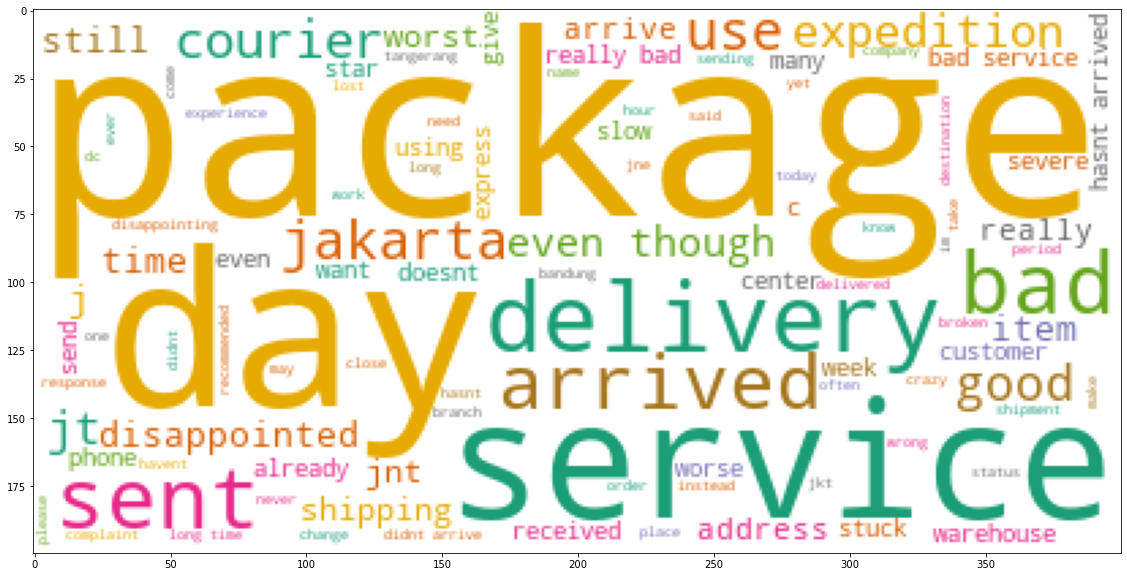

In [16]:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud)

In [17]:
late_words = ['slow', 'late', 'long']
df_late = df_neg[df_neg['reviews'].str.contains('|'.join(late_words))]
df_late = df_late.rename(columns ={'reviews':'Late reviews'})

In [18]:
df_late

,rating,Late reviews,sentiment
1,1.0,worst worst use courier youll regret later unp...,Negative
5,1.0,slow work item ordered still even delivery att...,Negative
19,1.0,competitor often late delivery estimation prob...,Negative
20,1.0,almost month package say delivery courier anja...,Negative
25,1.0,irresponsible missorted package arrive kupang ...,Negative
26,1.0,recommended ive waiting long time day apparent...,Negative
34,1.0,lately im disappointed jt really bad item wasn...,Negative
40,1.0,bad long delivery,Negative
49,1.0,crazy expedition package received sorting plac...,Negative
64,1.0,lelet expedition period bandung jakarta day st...,Negative


In [19]:
df_late.to_csv('Late_reviews_jnt.csv')